In [1]:
# Get the data for expeirment
import sklearn
import pandas as pd 
import numpy as np

from sklearn import tree
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn.metrics import explained_variance_score, mean_squared_error
from scipy.spatial.distance import cdist
from numpy.linalg import pinv
from math import sqrt

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import KFold

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import geopy.distance as distance
from sklearn.preprocessing import MinMaxScaler

import Data_utils

In [2]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras import datasets, layers, models, losses

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [43]:
all_data = pd.read_csv('Data/student_ab_wind.csv', encoding = "ISO-8859-1")


C:\Users\PPL\AppData\Local\Temp\ipykernel_48896\2175011519.py:1: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  all_data = pd.read_csv('Data/student_ab_wind.csv', encoding = "ISO-8859-1")


In [44]:
all_data

,longitude,latitude,name,id,date,temp,precip,wind_direction,wind_speed
0,-112.82,53.05,CAMROSE,3011240,2013-12-10 17:00,-20.9,0.0,19.0,6.0
1,-112.82,53.05,CAMROSE,3011240,2013-12-11 11:00,-11.0,0.0,1.0,4.0
2,-112.82,53.05,CAMROSE,3011240,2013-12-12 11:00,-17.0,0.0,8.0,17.0
3,-112.82,53.05,CAMROSE,3011240,2013-12-12 18:00,-19.0,0.0,9.0,16.0
4,-112.82,53.05,CAMROSE,3011240,2013-12-12 20:00,-19.7,0.0,10.0,19.0
...,...,...,...,...,...,...,...,...,...
511504,-115.28,56.55,RED EARTH,3075488,2023-07-20 04:00,10.8,0.0,14.0,4.0
511505,-115.28,56.55,RED EARTH,3075488,2023-07-20 05:00,11.0,0.0,14.0,1.0
511506,-115.28,56.55,RED EARTH,3075488,2023-07-20 18:00,25.4,0.0,30.0,4.0
511507,-115.28,56.55,RED EARTH,3075488,2023-07-20 21:00,19.4,0.0,0.0,1.0


In [5]:
teacher_model_training_data = pd.read_csv('Data/teacher_training_ab_wind.csv', encoding = "ISO-8859-1")

#teacher_model_training_data = teacher_model_training_data.sample(frac=0.2)

In [6]:
teacher_model_training_data.head(1)

,longitude,latitude,name,id,date,temp,precip,wind_direction,wind_speed
0,-110.47,49.12,ONEFOUR CDA,3044923,2013-12-10 16:00,-16.4,0.0,29.0,13.0


In [5]:
#teacher_model_testing_data = pd.read_csv('Data/teacher_test_ab_wind.csv', encoding = "ISO-8859-1")

In [6]:
#teacher_model_data = data.groupby('date').sample(frac=0.8, random_state = 123)

In [7]:
#teacher_model_data.to_csv('Data/teacher_ab_wind.csv', sep = ',', index = False)

In [8]:
#student_model_data = data[~data.index.isin(teacher_model_data.index)]

In [9]:
#student_model_data
#student_model_data.to_csv('Data/student_ab_wind.csv', sep = ',', index = False)

In [10]:
#teacher_model_training_data = teacher_model_data.groupby('date').sample(frac=0.7, random_state = 321)

In [11]:
#teacher_model_test_data = teacher_model_data[~teacher_model_data.index.isin(teacher_model_training_data.index)]

In [12]:
# teacher_model_training_data.to_csv('Data/teacher_training_ab_wind.csv', sep = ',', index = False)
# teacher_model_test_data.to_csv('Data/teacher_test_ab_wind.csv', sep = ',', index = False)

In [7]:
teacher_model_training_data['name'].unique() # 39 total

array(['ONEFOUR CDA', 'CAMROSE', 'MILK RIVER', 'SLAVE LAKE RCS',
       'LETHBRIDGE CDA', 'CORONATION CLIMATE', 'RED EARTH',
       'EDMONTON STONY PLAIN CS', 'VEGREVILLE', 'LACOMBE CDA 2',
       'FORT CHIPEWYAN RCS', 'CLARESHOLM', 'ROCKY MTN HOUSE (AUT)',
       'STRATHMORE AGDM', 'BROOKS', 'BANFF CS', 'MEDICINE HAT RCS',
       'JASPER WARDEN', 'SUNDRE A', 'FORT MCMURRAY CS',
       'PINCHER CREEK CLIMATE', 'BOW VALLEY', 'EDSON CLIMATE',
       'DRUMHELLER EAST', 'WHITECOURT', 'EDSON', 'MEDICINE HAT',
       'SLAVE LAKE', 'LLOYDMINSTER', 'HIGH LEVEL A', 'LETHBRIDGE',
       'FORT MCMURRAY A', 'FORT CHIPEWYAN', 'EDMONTON BLATCHFORD',
       "CALGARY INT'L CS", 'RED DEER REGIONAL A', 'HIGH LEVEL',
       'EDMONTON INTERNATIONAL CS', 'WHITECOURT A'], dtype=object)

Text(0.5, 0, 'Wind speed')

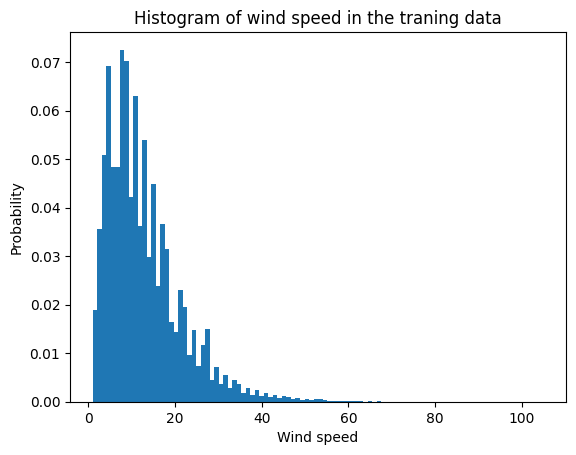

In [8]:
plt.hist(teacher_model_training_data['wind_speed'], bins=100, density=True)
plt.title("Histogram of wind speed in the traning data")
plt.ylabel("Probability")
plt.xlabel("Wind speed")

In [9]:
# Source: From the TSmodel
def preprocess_data(train, validation):
    scaler = StandardScaler()
    train_data = scaler.fit_transform(train)
    validation_data = scaler.transform(validation)
    
    return train_data, validation_data

In [10]:
def fcm_rule_model(train_x, train_y, validation_x, validation_y):
    # Fcm hyperparameters
    FCM_Nc = 10
    FCM_m = 2
    tol = 1e-5
    max_iter = 100

    
    N = train_x.shape[0]
    U = np.random.rand(N, FCM_Nc)
    U = U / np.sum(U, axis=1, keepdims=True)

    # Fuzzy C-Means 聚类
    for _ in range(max_iter):
        U_old = U.copy()
        mf = U ** FCM_m
        cen = np.dot(mf.T, train_x) / np.sum(mf, axis=0, keepdims=True).T
        dists = cdist(train_x, cen)
        tmp = np.power(dists, -2 / (FCM_m - 1))
        U = tmp / np.sum(tmp, axis=1, keepdims=True)

        # 检查是否收敛
        if np.linalg.norm(U - U_old) < tol:
            break

    # 模型训练
    z = np.hstack((np.ones((N, 1)), train_x))
    H = np.zeros((N, FCM_Nc * (train_x.shape[1] + 1)))

    # 生成模糊规则矩阵 H
    for j in range(FCM_Nc):
        Uj = np.tile(U[:, j], (train_x.shape[1] + 1, 1)).T
        H[:, (j * (train_x.shape[1] + 1)):((j + 1) * (train_x.shape[1] + 1))] = Uj * z

    # 计算权重 W
    W = pinv(np.dot(H.T, H)).dot(H.T).dot(train_y)

    # 在训练集上进行预测
    y_hat_train = np.dot(H, W)
    mse_train = mean_squared_error(train_y, y_hat_train)
    rmse_train = sqrt(mean_squared_error(train_y, y_hat_train))
    print("FCM traning RMSE:", rmse_train)
    
    # validation
    N_validation = validation_x.shape[0]
    z_validation = np.hstack((np.ones((N_validation, 1)), validation_x))
    H_validation = np.zeros((N_validation, FCM_Nc * (validation_x.shape[1] + 1)))
    dists_validation = cdist(validation_x, cen)
    tmp_validation = np.power(dists_validation, -2 / (FCM_m - 1))
    U_validation = tmp_validation / np.sum(tmp_validation, axis=1, keepdims=True)

    # 生成模糊规则矩阵 H_test
    for j in range(FCM_Nc):
        Uj_validation = np.tile(U_validation[:, j], (validation_x.shape[1] + 1, 1)).T
        H_validation[:, (j * (validation_x.shape[1] + 1)):((j + 1) * (validation_x.shape[1] + 1))] = Uj_validation * z_validation

    # validation set
    y_hat_validation = np.dot(H_validation, W)
    mse_validation = mean_squared_error(validation_y, y_hat_validation)
    rmse_validation = sqrt(mse_validation)
    print("FCM val RMSE:", rmse_validation)
    
    return rmse_train, rmse_validation

    # 模型测试
#     N_test = test_x.shape[0]
#     z_test = np.hstack((np.ones((N_test, 1)), test_x))
#     H_test = np.zeros((N_test, FCM_Nc * (test_x.shape[1] + 1)))
#     dists_test = cdist(test_x, cen)
#     tmp_test = np.power(dists_test, -2 / (FCM_m - 1))
#     U_test = tmp_test / np.sum(tmp_test, axis=1, keepdims=True)

#     # 生成模糊规则矩阵 H_test
#     for j in range(FCM_Nc):
#         Uj_test = np.tile(U_test[:, j], (test_x.shape[1] + 1, 1)).T
#         H_test[:, (j * (test_x.shape[1] + 1)):((j + 1) * (test_x.shape[1] + 1))] = Uj_test * z_test

#     # 在测试集上进行预测
#     y_hat_test = np.dot(H_test, W)
#     mse_test = mean_squared_error(test_y, y_hat_test)
#     rmse_test = sqrt(mean_squared_error(test_y, y_hat_test))
#     print("test MSE:", mse_test)
#     print("test RMSE:", rmse_test)
#     test_results.append({'fcm_test':rmse_test})
    
        
#     print('r2 score')
#     print(r2_score(test_y, y_hat_test))


    # 绘制拟合曲线
#     plt.figure()
#     plt.subplot(1, 2, 1)
#     plt.scatter(range(len(train_y)), train_y, c='blue', label='Target')
#     plt.scatter(range(len(y_hat_train)), y_hat_train, c='red', label='Predict')
#     plt.title('Training')
#     plt.legend()

#     plt.subplot(1, 2, 2)
#     plt.scatter(range(len(test_y)), test_y, c='blue', label='Target')
#     plt.scatter(range(len(y_hat_test)), y_hat_test, c='red', label='Predict')
#     plt.title('Testing')
#     plt.legend()
#     plt.show()

In [11]:
def linear_model(train_x, train_y, validation_x, validation_y):
    reg = LinearRegression().fit(train_x, train_y)
        
    train_pred = reg.predict(train_x)
    
    validation_pred = reg.predict(validation_x)
    
    print("linear train")
    print(mean_squared_error(train_y, train_pred, squared = False))
    
    print("linear_validation")
    print(mean_squared_error(validation_y, validation_pred, squared = False))
    
    return mean_squared_error(train_y, train_pred, squared = False), mean_squared_error(validation_y, validation_pred, squared = False)

In [12]:
def build_neural_network_model():
    model = models.Sequential()
    
    model.add(layers.Dense(30, activation=tf.keras.activations.tanh))    
    model.add(layers.Dense(1))    
    
    return model

In [13]:
def neural_network_model(train_x, train_y, validation_x, validation_y):
    neural_network_model = build_neural_network_model()
    
    neural_network_model.compile(
        optimizer='adam',
        loss=tf.keras.losses.MeanSquaredError(),
        metrics=[tf.keras.metrics.RootMeanSquaredError()]
    )
    
    history = neural_network_model.fit(
        train_x, 
        train_y, 
        epochs=number_of_epochs, 
        validation_data=(validation_x, validation_y)
    )
    
    return history, np.mean(np.array(history.history['root_mean_squared_error'])), np.mean(np.array(history.history['val_root_mean_squared_error']))

In [14]:
# hyperparameters for the expeirment
number_of_neighbour_stations = [1,2,3,4,5,6]
number_of_epochs = 50

# Expeirment related parameters
number_of_folds = 10
# General hyperparameter
max_threshold_distance = 200 #km
min_threshold_distance = 2 #km

# Results containers
training_results = []
validation_results = []
nn_histories = []

# Determine the optimal value for the given hyperparameter
def do_experiment(hyper_parameter_to_test_values):
    kf = KFold(n_splits=number_of_folds)
    
    for hyperparameter_value in hyper_parameter_to_test_values:
        # First fitler the data based on the settings
        train_x = []
        train_y = []
        
        for station in teacher_model_training_data['name'].unique():
            features, target = Data_utils.generate_data(
                teacher_model_training_data, 
                station, 
                hyperparameter_value, 
                max_threshold_distance, 
                min_threshold_distance
            )
    
            if (len(features)!=0) & (len(target)!=0):
                np_features = np.array(features)
                np_target = np.array(target)

                train_x.append(np_features)
                train_y.append(np_target)
                
        # After all stations are filtered, flatten the data into a huge list        
        flatten_x =  np.array([data for sublist in train_x for data in sublist])
        flatten_y =  np.array([data for sublist in train_y for data in sublist])
        
        # After all data are ready, do a 10 fold cross validation
        training_results_fold = []
        validation_results_fold = []
        test_results_fold = []
        nn_history_fold = []
        
        for i, (train_index, val_index) in enumerate(kf.split(flatten_x)):
            split_train_x = flatten_x[train_index]
            split_train_y = flatten_y[train_index]

            split_val_x = flatten_x[val_index]
            split_val_y = flatten_y[val_index]
            # Normalize the input
            split_train_x, split_val_x = preprocess_data(split_train_x, split_val_x)            
            # Linear model
            li_train_rmse, li_val_rmse = linear_model(split_train_x, split_train_y, split_val_x , split_val_y)
            training_results_fold.append({'linear_train' : li_train_rmse})
            validation_results_fold.append({'linear_val' : li_val_rmse})
            
            # FCM model
            fcm_train_rmse, fcm_val_rmse = fcm_rule_model(split_train_x, split_train_y, split_val_x , split_val_y)
            training_results_fold.append({'fcm_train' : fcm_train_rmse})
            validation_results_fold.append({'fcm_val' : fcm_val_rmse})
            
            # NN
            nn_history, nn_train_rmse, nn_val_rmse = neural_network_model(split_train_x, split_train_y, split_val_x , split_val_y)
            nn_history_fold.append(nn_history.history)
            training_results_fold.append({'nn_train' : nn_train_rmse})
            validation_results_fold.append({'nn_val' : nn_val_rmse})
        
        #After all folds are done, update the result containers
        training_results.append(training_results_fold)
        validation_results.append(validation_results_fold)
        nn_histories.append(nn_history_fold)
        
        

In [15]:
do_experiment(number_of_neighbour_stations)

target FORT CHIPEWYAN RCS has neightbour_stations 0 not match number_of_neighbours 1
target FORT MCMURRAY CS has neightbour_stations 0 not match number_of_neighbours 1
target HIGH LEVEL A has neightbour_stations 0 not match number_of_neighbours 1
target FORT MCMURRAY A has neightbour_stations 0 not match number_of_neighbours 1
target FORT CHIPEWYAN has neightbour_stations 0 not match number_of_neighbours 1
target HIGH LEVEL has neightbour_stations 0 not match number_of_neighbours 1
linear train
6.667475031207172
linear_validation
4757246999840.97
FCM traning RMSE: 6.637893977925486
FCM val RMSE: 11599.54880893099
Epoch 1/50
12468/12468 [==============================] - 18s 1ms/step - loss: 53.2097 - root_mean_squared_error: 7.2945 - val_loss: 109.2114 - val_root_mean_squared_error: 10.4504
Epoch 2/50
12468/12468 [==============================] - 18s 1ms/step - loss: 42.9161 - root_mean_squared_error: 6.5510 - val_loss: 102.7224 - val_root_mean_squared_error: 10.1352
Epoch 3/50
12468/

12468/12468 [==============================] - 17s 1ms/step - loss: 38.1295 - root_mean_squared_error: 6.1749 - val_loss: 86.7136 - val_root_mean_squared_error: 9.3120
Epoch 44/50
12468/12468 [==============================] - 17s 1ms/step - loss: 38.1279 - root_mean_squared_error: 6.1748 - val_loss: 88.9354 - val_root_mean_squared_error: 9.4306
Epoch 45/50
12468/12468 [==============================] - 17s 1ms/step - loss: 38.1371 - root_mean_squared_error: 6.1755 - val_loss: 86.0439 - val_root_mean_squared_error: 9.2760
Epoch 46/50
12468/12468 [==============================] - 17s 1ms/step - loss: 38.1228 - root_mean_squared_error: 6.1744 - val_loss: 84.0399 - val_root_mean_squared_error: 9.1673
Epoch 47/50
12468/12468 [==============================] - 17s 1ms/step - loss: 38.1136 - root_mean_squared_error: 6.1736 - val_loss: 85.9474 - val_root_mean_squared_error: 9.2708
Epoch 48/50
12468/12468 [==============================] - 17s 1ms/step - loss: 38.0972 - root_mean_squared_erro

Epoch 38/50
12468/12468 [==============================] - 17s 1ms/step - loss: 40.9095 - root_mean_squared_error: 6.3961 - val_loss: 80.7750 - val_root_mean_squared_error: 8.9875
Epoch 39/50
12468/12468 [==============================] - 16s 1ms/step - loss: 40.9377 - root_mean_squared_error: 6.3983 - val_loss: 89.0072 - val_root_mean_squared_error: 9.4344
Epoch 40/50
12468/12468 [==============================] - 17s 1ms/step - loss: 40.9018 - root_mean_squared_error: 6.3955 - val_loss: 91.0947 - val_root_mean_squared_error: 9.5444
Epoch 41/50
12468/12468 [==============================] - 18s 1ms/step - loss: 40.8723 - root_mean_squared_error: 6.3931 - val_loss: 86.9220 - val_root_mean_squared_error: 9.3232
Epoch 42/50
12468/12468 [==============================] - 17s 1ms/step - loss: 40.8631 - root_mean_squared_error: 6.3924 - val_loss: 91.1241 - val_root_mean_squared_error: 9.5459
Epoch 43/50
12468/12468 [==============================] - 17s 1ms/step - loss: 40.8464 - root_mean_

Epoch 33/50
12468/12468 [==============================] - 17s 1ms/step - loss: 43.2984 - root_mean_squared_error: 6.5802 - val_loss: 39.7036 - val_root_mean_squared_error: 6.3011
Epoch 34/50
12468/12468 [==============================] - 17s 1ms/step - loss: 43.2825 - root_mean_squared_error: 6.5789 - val_loss: 41.8298 - val_root_mean_squared_error: 6.4676
Epoch 35/50
12468/12468 [==============================] - 17s 1ms/step - loss: 43.2252 - root_mean_squared_error: 6.5746 - val_loss: 40.2654 - val_root_mean_squared_error: 6.3455
Epoch 36/50
12468/12468 [==============================] - 18s 1ms/step - loss: 43.2288 - root_mean_squared_error: 6.5749 - val_loss: 41.9607 - val_root_mean_squared_error: 6.4777
Epoch 37/50
12468/12468 [==============================] - 18s 1ms/step - loss: 43.1914 - root_mean_squared_error: 6.5720 - val_loss: 40.9959 - val_root_mean_squared_error: 6.4028
Epoch 38/50
12468/12468 [==============================] - 17s 1ms/step - loss: 43.2130 - root_mean_

12468/12468 [==============================] - 17s 1ms/step - loss: 39.9837 - root_mean_squared_error: 6.3233 - val_loss: 96.5453 - val_root_mean_squared_error: 9.8257
Epoch 28/50
12468/12468 [==============================] - 17s 1ms/step - loss: 39.9778 - root_mean_squared_error: 6.3228 - val_loss: 97.7335 - val_root_mean_squared_error: 9.8860
Epoch 29/50
12468/12468 [==============================] - 17s 1ms/step - loss: 39.9520 - root_mean_squared_error: 6.3208 - val_loss: 88.3143 - val_root_mean_squared_error: 9.3976
Epoch 30/50
12468/12468 [==============================] - 17s 1ms/step - loss: 39.9342 - root_mean_squared_error: 6.3194 - val_loss: 95.7633 - val_root_mean_squared_error: 9.7859
Epoch 31/50
12468/12468 [==============================] - 17s 1ms/step - loss: 39.8950 - root_mean_squared_error: 6.3162 - val_loss: 99.7114 - val_root_mean_squared_error: 9.9856
Epoch 32/50
12468/12468 [==============================] - 17s 1ms/step - loss: 39.8512 - root_mean_squared_erro

Epoch 22/50
12468/12468 [==============================] - 17s 1ms/step - loss: 42.1713 - root_mean_squared_error: 6.4939 - val_loss: 49.1121 - val_root_mean_squared_error: 7.0080
Epoch 23/50
12468/12468 [==============================] - 17s 1ms/step - loss: 42.1071 - root_mean_squared_error: 6.4890 - val_loss: 51.4204 - val_root_mean_squared_error: 7.1708
Epoch 24/50
12468/12468 [==============================] - 17s 1ms/step - loss: 42.0482 - root_mean_squared_error: 6.4845 - val_loss: 49.5665 - val_root_mean_squared_error: 7.0403
Epoch 25/50
12468/12468 [==============================] - 17s 1ms/step - loss: 42.0092 - root_mean_squared_error: 6.4815 - val_loss: 52.5015 - val_root_mean_squared_error: 7.2458
Epoch 26/50
12468/12468 [==============================] - 17s 1ms/step - loss: 41.9498 - root_mean_squared_error: 6.4769 - val_loss: 53.6090 - val_root_mean_squared_error: 7.3218
Epoch 27/50
12468/12468 [==============================] - 17s 1ms/step - loss: 41.9085 - root_mean_

Epoch 17/50
12468/12468 [==============================] - 18s 1ms/step - loss: 42.4987 - root_mean_squared_error: 6.5191 - val_loss: 49.1774 - val_root_mean_squared_error: 7.0127
Epoch 18/50
12468/12468 [==============================] - 17s 1ms/step - loss: 42.4321 - root_mean_squared_error: 6.5140 - val_loss: 49.8950 - val_root_mean_squared_error: 7.0636
Epoch 19/50
12468/12468 [==============================] - 17s 1ms/step - loss: 42.3872 - root_mean_squared_error: 6.5105 - val_loss: 46.7129 - val_root_mean_squared_error: 6.8347
Epoch 20/50
12468/12468 [==============================] - 18s 1ms/step - loss: 42.3170 - root_mean_squared_error: 6.5051 - val_loss: 49.7438 - val_root_mean_squared_error: 7.0529
Epoch 21/50
12468/12468 [==============================] - 17s 1ms/step - loss: 42.2695 - root_mean_squared_error: 6.5015 - val_loss: 50.6064 - val_root_mean_squared_error: 7.1138
Epoch 22/50
12468/12468 [==============================] - 17s 1ms/step - loss: 42.2665 - root_mean_

Epoch 12/50
12468/12468 [==============================] - 17s 1ms/step - loss: 39.4754 - root_mean_squared_error: 6.2829 - val_loss: 91.6555 - val_root_mean_squared_error: 9.5737
Epoch 13/50
12468/12468 [==============================] - 17s 1ms/step - loss: 39.3654 - root_mean_squared_error: 6.2742 - val_loss: 90.5105 - val_root_mean_squared_error: 9.5137
Epoch 14/50
12468/12468 [==============================] - 17s 1ms/step - loss: 39.2877 - root_mean_squared_error: 6.2680 - val_loss: 90.0426 - val_root_mean_squared_error: 9.4891
Epoch 15/50
12468/12468 [==============================] - 16s 1ms/step - loss: 39.1955 - root_mean_squared_error: 6.2606 - val_loss: 91.2253 - val_root_mean_squared_error: 9.5512
Epoch 16/50
12468/12468 [==============================] - 17s 1ms/step - loss: 39.1551 - root_mean_squared_error: 6.2574 - val_loss: 93.4983 - val_root_mean_squared_error: 9.6694
Epoch 17/50
12468/12468 [==============================] - 17s 1ms/step - loss: 39.0827 - root_mean_

Epoch 7/50
12468/12468 [==============================] - 17s 1ms/step - loss: 42.9537 - root_mean_squared_error: 6.5539 - val_loss: 68.5224 - val_root_mean_squared_error: 8.2778
Epoch 8/50
12468/12468 [==============================] - 17s 1ms/step - loss: 42.6120 - root_mean_squared_error: 6.5278 - val_loss: 65.7919 - val_root_mean_squared_error: 8.1112
Epoch 9/50
12468/12468 [==============================] - 17s 1ms/step - loss: 42.3381 - root_mean_squared_error: 6.5068 - val_loss: 67.2437 - val_root_mean_squared_error: 8.2002
Epoch 10/50
12468/12468 [==============================] - 17s 1ms/step - loss: 42.1097 - root_mean_squared_error: 6.4892 - val_loss: 64.2034 - val_root_mean_squared_error: 8.0127
Epoch 11/50
12468/12468 [==============================] - 17s 1ms/step - loss: 41.9338 - root_mean_squared_error: 6.4756 - val_loss: 65.5952 - val_root_mean_squared_error: 8.0991
Epoch 12/50
12468/12468 [==============================] - 17s 1ms/step - loss: 41.7387 - root_mean_squ

Epoch 2/50
12468/12468 [==============================] - 18s 1ms/step - loss: 46.2125 - root_mean_squared_error: 6.7980 - val_loss: 86.1490 - val_root_mean_squared_error: 9.2816
Epoch 3/50
12468/12468 [==============================] - 17s 1ms/step - loss: 45.2215 - root_mean_squared_error: 6.7247 - val_loss: 90.4539 - val_root_mean_squared_error: 9.5107
Epoch 4/50
12468/12468 [==============================] - 17s 1ms/step - loss: 44.4506 - root_mean_squared_error: 6.6671 - val_loss: 89.6508 - val_root_mean_squared_error: 9.4684
Epoch 5/50
12468/12468 [==============================] - 17s 1ms/step - loss: 43.7931 - root_mean_squared_error: 6.6176 - val_loss: 93.2235 - val_root_mean_squared_error: 9.6552
Epoch 6/50
12468/12468 [==============================] - 17s 1ms/step - loss: 43.2598 - root_mean_squared_error: 6.5772 - val_loss: 102.3808 - val_root_mean_squared_error: 10.1183
Epoch 7/50
12468/12468 [==============================] - 17s 1ms/step - loss: 42.9070 - root_mean_squa

12468/12468 [==============================] - 17s 1ms/step - loss: 40.6528 - root_mean_squared_error: 6.3760 - val_loss: 75.0078 - val_root_mean_squared_error: 8.6607
Epoch 48/50
12468/12468 [==============================] - 17s 1ms/step - loss: 40.6345 - root_mean_squared_error: 6.3745 - val_loss: 69.4036 - val_root_mean_squared_error: 8.3309
Epoch 49/50
12468/12468 [==============================] - 17s 1ms/step - loss: 40.6467 - root_mean_squared_error: 6.3755 - val_loss: 73.3588 - val_root_mean_squared_error: 8.5650
Epoch 50/50
12468/12468 [==============================] - 17s 1ms/step - loss: 40.6290 - root_mean_squared_error: 6.3741 - val_loss: 67.0269 - val_root_mean_squared_error: 8.1870
linear train
6.9989906246963445
linear_validation
1906734468918.0288
FCM traning RMSE: 6.946760936630661
FCM val RMSE: 49240.94418725296
Epoch 1/50
12468/12468 [==============================] - 17s 1ms/step - loss: 59.3462 - root_mean_squared_error: 7.7036 - val_loss: 50.2164 - val_root_mea

Epoch 42/50
12468/12468 [==============================] - 18s 1ms/step - loss: 42.0520 - root_mean_squared_error: 6.4848 - val_loss: 45.6876 - val_root_mean_squared_error: 6.7593
Epoch 43/50
12468/12468 [==============================] - 17s 1ms/step - loss: 42.0707 - root_mean_squared_error: 6.4862 - val_loss: 47.0285 - val_root_mean_squared_error: 6.8577
Epoch 44/50
12468/12468 [==============================] - 17s 1ms/step - loss: 42.0347 - root_mean_squared_error: 6.4834 - val_loss: 47.6929 - val_root_mean_squared_error: 6.9060
Epoch 45/50
12468/12468 [==============================] - 17s 1ms/step - loss: 42.0391 - root_mean_squared_error: 6.4838 - val_loss: 44.8053 - val_root_mean_squared_error: 6.6937
Epoch 46/50
12468/12468 [==============================] - 17s 1ms/step - loss: 42.0145 - root_mean_squared_error: 6.4819 - val_loss: 46.0136 - val_root_mean_squared_error: 6.7833
Epoch 47/50
12468/12468 [==============================] - 17s 1ms/step - loss: 41.9954 - root_mean_

5165/5165 [==============================] - 7s 1ms/step - loss: 36.6270 - root_mean_squared_error: 6.0520 - val_loss: 126.2075 - val_root_mean_squared_error: 11.2342
Epoch 35/50
5165/5165 [==============================] - 7s 1ms/step - loss: 36.6034 - root_mean_squared_error: 6.0501 - val_loss: 116.2568 - val_root_mean_squared_error: 10.7822
Epoch 36/50
5165/5165 [==============================] - 7s 1ms/step - loss: 36.5411 - root_mean_squared_error: 6.0449 - val_loss: 140.6679 - val_root_mean_squared_error: 11.8603
Epoch 37/50
5165/5165 [==============================] - 7s 1ms/step - loss: 36.4875 - root_mean_squared_error: 6.0405 - val_loss: 124.8911 - val_root_mean_squared_error: 11.1755
Epoch 38/50
5165/5165 [==============================] - 7s 1ms/step - loss: 36.4802 - root_mean_squared_error: 6.0399 - val_loss: 139.4390 - val_root_mean_squared_error: 11.8084
Epoch 39/50
5165/5165 [==============================] - 7s 1ms/step - loss: 36.4459 - root_mean_squared_error: 6.037

5165/5165 [==============================] - 7s 1ms/step - loss: 39.2979 - root_mean_squared_error: 6.2688 - val_loss: 110.2947 - val_root_mean_squared_error: 10.5021
Epoch 30/50
5165/5165 [==============================] - 7s 1ms/step - loss: 39.2534 - root_mean_squared_error: 6.2653 - val_loss: 107.0162 - val_root_mean_squared_error: 10.3449
Epoch 31/50
5165/5165 [==============================] - 7s 1ms/step - loss: 39.2273 - root_mean_squared_error: 6.2632 - val_loss: 106.3891 - val_root_mean_squared_error: 10.3145
Epoch 32/50
5165/5165 [==============================] - 7s 1ms/step - loss: 39.1423 - root_mean_squared_error: 6.2564 - val_loss: 105.7204 - val_root_mean_squared_error: 10.2820
Epoch 33/50
5165/5165 [==============================] - 7s 1ms/step - loss: 39.1251 - root_mean_squared_error: 6.2550 - val_loss: 107.9284 - val_root_mean_squared_error: 10.3889
Epoch 34/50
5165/5165 [==============================] - 7s 1ms/step - loss: 39.0962 - root_mean_squared_error: 6.252

5165/5165 [==============================] - 7s 1ms/step - loss: 42.6521 - root_mean_squared_error: 6.5309 - val_loss: 91.1312 - val_root_mean_squared_error: 9.5463
Epoch 25/50
5165/5165 [==============================] - 7s 1ms/step - loss: 42.5939 - root_mean_squared_error: 6.5264 - val_loss: 91.7527 - val_root_mean_squared_error: 9.5788
Epoch 26/50
5165/5165 [==============================] - 7s 1ms/step - loss: 42.5181 - root_mean_squared_error: 6.5206 - val_loss: 89.8688 - val_root_mean_squared_error: 9.4799
Epoch 27/50
5165/5165 [==============================] - 7s 1ms/step - loss: 42.4197 - root_mean_squared_error: 6.5130 - val_loss: 94.6567 - val_root_mean_squared_error: 9.7292
Epoch 28/50
5165/5165 [==============================] - 7s 1ms/step - loss: 42.3788 - root_mean_squared_error: 6.5099 - val_loss: 104.1635 - val_root_mean_squared_error: 10.2061
Epoch 29/50
5165/5165 [==============================] - 7s 1ms/step - loss: 42.2702 - root_mean_squared_error: 6.5016 - val_

5165/5165 [==============================] - 7s 1ms/step - loss: 40.8264 - root_mean_squared_error: 6.3896 - val_loss: 69.3669 - val_root_mean_squared_error: 8.3287
Epoch 20/50
5165/5165 [==============================] - 7s 1ms/step - loss: 40.7500 - root_mean_squared_error: 6.3836 - val_loss: 73.9079 - val_root_mean_squared_error: 8.5970
Epoch 21/50
5165/5165 [==============================] - 7s 1ms/step - loss: 40.6699 - root_mean_squared_error: 6.3773 - val_loss: 82.5013 - val_root_mean_squared_error: 9.0830
Epoch 22/50
5165/5165 [==============================] - 7s 1ms/step - loss: 40.5606 - root_mean_squared_error: 6.3687 - val_loss: 78.0836 - val_root_mean_squared_error: 8.8365
Epoch 23/50
5165/5165 [==============================] - 7s 1ms/step - loss: 40.4658 - root_mean_squared_error: 6.3613 - val_loss: 79.1489 - val_root_mean_squared_error: 8.8966
Epoch 24/50
5165/5165 [==============================] - 7s 1ms/step - loss: 40.4291 - root_mean_squared_error: 6.3584 - val_lo

5165/5165 [==============================] - 7s 1ms/step - loss: 42.1698 - root_mean_squared_error: 6.4938 - val_loss: 176.1412 - val_root_mean_squared_error: 13.2718
Epoch 15/50
5165/5165 [==============================] - 7s 1ms/step - loss: 41.9460 - root_mean_squared_error: 6.4766 - val_loss: 164.1521 - val_root_mean_squared_error: 12.8122
Epoch 16/50
5165/5165 [==============================] - 7s 1ms/step - loss: 41.8108 - root_mean_squared_error: 6.4661 - val_loss: 171.6542 - val_root_mean_squared_error: 13.1017
Epoch 17/50
5165/5165 [==============================] - 7s 1ms/step - loss: 41.6667 - root_mean_squared_error: 6.4550 - val_loss: 172.0452 - val_root_mean_squared_error: 13.1166
Epoch 18/50
5165/5165 [==============================] - 7s 1ms/step - loss: 41.5513 - root_mean_squared_error: 6.4460 - val_loss: 174.5183 - val_root_mean_squared_error: 13.2105
Epoch 19/50
5165/5165 [==============================] - 7s 1ms/step - loss: 41.4726 - root_mean_squared_error: 6.439

5165/5165 [==============================] - 7s 1ms/step - loss: 43.9089 - root_mean_squared_error: 6.6264 - val_loss: 118.9090 - val_root_mean_squared_error: 10.9045
Epoch 10/50
5165/5165 [==============================] - 7s 1ms/step - loss: 43.5991 - root_mean_squared_error: 6.6030 - val_loss: 104.0301 - val_root_mean_squared_error: 10.1995
Epoch 11/50
5165/5165 [==============================] - 7s 1ms/step - loss: 43.3073 - root_mean_squared_error: 6.5808 - val_loss: 97.3287 - val_root_mean_squared_error: 9.8655
Epoch 12/50
5165/5165 [==============================] - 7s 1ms/step - loss: 43.0572 - root_mean_squared_error: 6.5618 - val_loss: 97.6951 - val_root_mean_squared_error: 9.8841
Epoch 13/50
5165/5165 [==============================] - 7s 1ms/step - loss: 42.7927 - root_mean_squared_error: 6.5416 - val_loss: 110.1059 - val_root_mean_squared_error: 10.4931
Epoch 14/50
5165/5165 [==============================] - 7s 1ms/step - loss: 42.5751 - root_mean_squared_error: 6.5250 - 

5165/5165 [==============================] - 7s 1ms/step - loss: 42.3379 - root_mean_squared_error: 6.5068 - val_loss: 74.7052 - val_root_mean_squared_error: 8.6432
Epoch 5/50
5165/5165 [==============================] - 7s 1ms/step - loss: 41.6311 - root_mean_squared_error: 6.4522 - val_loss: 73.3008 - val_root_mean_squared_error: 8.5616
Epoch 6/50
5165/5165 [==============================] - 7s 1ms/step - loss: 41.0696 - root_mean_squared_error: 6.4086 - val_loss: 74.8165 - val_root_mean_squared_error: 8.6497
Epoch 7/50
5165/5165 [==============================] - 7s 1ms/step - loss: 40.5234 - root_mean_squared_error: 6.3658 - val_loss: 76.0148 - val_root_mean_squared_error: 8.7186
Epoch 8/50
5165/5165 [==============================] - 7s 1ms/step - loss: 40.0925 - root_mean_squared_error: 6.3319 - val_loss: 74.0812 - val_root_mean_squared_error: 8.6070
Epoch 9/50
5165/5165 [==============================] - 7s 1ms/step - loss: 39.7066 - root_mean_squared_error: 6.3013 - val_loss: 7

5165/5165 [==============================] - 7s 1ms/step - loss: 36.4579 - root_mean_squared_error: 6.0380 - val_loss: 76.0959 - val_root_mean_squared_error: 8.7233
linear train
6.896450329693126
linear_validation
7995637580285.953
FCM traning RMSE: 6.871270905714698
FCM val RMSE: 224.4817797614459
Epoch 1/50
5165/5165 [==============================] - 7s 1ms/step - loss: 66.4975 - root_mean_squared_error: 8.1546 - val_loss: 63.8202 - val_root_mean_squared_error: 7.9888
Epoch 2/50
5165/5165 [==============================] - 7s 1ms/step - loss: 47.5251 - root_mean_squared_error: 6.8938 - val_loss: 66.8891 - val_root_mean_squared_error: 8.1786
Epoch 3/50
5165/5165 [==============================] - 7s 1ms/step - loss: 46.0836 - root_mean_squared_error: 6.7885 - val_loss: 68.7883 - val_root_mean_squared_error: 8.2939
Epoch 4/50
5165/5165 [==============================] - 7s 1ms/step - loss: 44.9959 - root_mean_squared_error: 6.7079 - val_loss: 74.7239 - val_root_mean_squared_error: 8.6

5165/5165 [==============================] - 7s 1ms/step - loss: 39.2967 - root_mean_squared_error: 6.2687 - val_loss: 72.4920 - val_root_mean_squared_error: 8.5142
Epoch 46/50
5165/5165 [==============================] - 7s 1ms/step - loss: 39.2777 - root_mean_squared_error: 6.2672 - val_loss: 75.1760 - val_root_mean_squared_error: 8.6704
Epoch 47/50
5165/5165 [==============================] - 7s 1ms/step - loss: 39.2465 - root_mean_squared_error: 6.2647 - val_loss: 71.5301 - val_root_mean_squared_error: 8.4575
Epoch 48/50
5165/5165 [==============================] - 7s 1ms/step - loss: 39.2799 - root_mean_squared_error: 6.2674 - val_loss: 80.5027 - val_root_mean_squared_error: 8.9723
Epoch 49/50
5165/5165 [==============================] - 7s 1ms/step - loss: 39.1952 - root_mean_squared_error: 6.2606 - val_loss: 69.9602 - val_root_mean_squared_error: 8.3642
Epoch 50/50
5165/5165 [==============================] - 7s 1ms/step - loss: 39.1985 - root_mean_squared_error: 6.2609 - val_lo

5165/5165 [==============================] - 7s 1ms/step - loss: 39.2980 - root_mean_squared_error: 6.2688 - val_loss: 229.3546 - val_root_mean_squared_error: 15.1445
Epoch 41/50
5165/5165 [==============================] - 7s 1ms/step - loss: 39.2832 - root_mean_squared_error: 6.2676 - val_loss: 217.0071 - val_root_mean_squared_error: 14.7312
Epoch 42/50
5165/5165 [==============================] - 7s 1ms/step - loss: 39.2712 - root_mean_squared_error: 6.2667 - val_loss: 234.0955 - val_root_mean_squared_error: 15.3002
Epoch 43/50
5165/5165 [==============================] - 7s 1ms/step - loss: 39.2245 - root_mean_squared_error: 6.2629 - val_loss: 220.0991 - val_root_mean_squared_error: 14.8357
Epoch 44/50
5165/5165 [==============================] - 7s 1ms/step - loss: 39.2034 - root_mean_squared_error: 6.2613 - val_loss: 232.8967 - val_root_mean_squared_error: 15.2610
Epoch 45/50
5165/5165 [==============================] - 7s 1ms/step - loss: 39.1306 - root_mean_squared_error: 6.255

5165/5165 [==============================] - 7s 1ms/step - loss: 40.2295 - root_mean_squared_error: 6.3427 - val_loss: 56.2919 - val_root_mean_squared_error: 7.5028
Epoch 36/50
5165/5165 [==============================] - 7s 1ms/step - loss: 40.1769 - root_mean_squared_error: 6.3385 - val_loss: 53.1670 - val_root_mean_squared_error: 7.2916
Epoch 37/50
5165/5165 [==============================] - 7s 1ms/step - loss: 40.1255 - root_mean_squared_error: 6.3345 - val_loss: 55.1618 - val_root_mean_squared_error: 7.4271
Epoch 38/50
5165/5165 [==============================] - 7s 1ms/step - loss: 40.1171 - root_mean_squared_error: 6.3338 - val_loss: 56.3740 - val_root_mean_squared_error: 7.5083
Epoch 39/50
5165/5165 [==============================] - 7s 1ms/step - loss: 40.0326 - root_mean_squared_error: 6.3271 - val_loss: 57.0224 - val_root_mean_squared_error: 7.5513
Epoch 40/50
5165/5165 [==============================] - 7s 1ms/step - loss: 40.0227 - root_mean_squared_error: 6.3263 - val_lo

Epoch 27/50
2055/2055 [==============================] - 3s 1ms/step - loss: 38.5442 - root_mean_squared_error: 6.2084 - val_loss: 163.3902 - val_root_mean_squared_error: 12.7824
Epoch 28/50
2055/2055 [==============================] - 3s 1ms/step - loss: 38.5351 - root_mean_squared_error: 6.2077 - val_loss: 171.4057 - val_root_mean_squared_error: 13.0922
Epoch 29/50
2055/2055 [==============================] - 3s 1ms/step - loss: 38.3432 - root_mean_squared_error: 6.1922 - val_loss: 167.0766 - val_root_mean_squared_error: 12.9258
Epoch 30/50
2055/2055 [==============================] - 3s 1ms/step - loss: 38.3690 - root_mean_squared_error: 6.1943 - val_loss: 164.7392 - val_root_mean_squared_error: 12.8351
Epoch 31/50
2055/2055 [==============================] - 3s 1ms/step - loss: 38.2959 - root_mean_squared_error: 6.1884 - val_loss: 161.6561 - val_root_mean_squared_error: 12.7144
Epoch 32/50
2055/2055 [==============================] - 3s 1ms/step - loss: 38.2500 - root_mean_squared_

2055/2055 [==============================] - 3s 1ms/step - loss: 41.2035 - root_mean_squared_error: 6.4190 - val_loss: 72.4652 - val_root_mean_squared_error: 8.5126
Epoch 23/50
2055/2055 [==============================] - 3s 1ms/step - loss: 41.1509 - root_mean_squared_error: 6.4149 - val_loss: 56.6218 - val_root_mean_squared_error: 7.5247
Epoch 24/50
2055/2055 [==============================] - 3s 1ms/step - loss: 41.0191 - root_mean_squared_error: 6.4046 - val_loss: 56.1087 - val_root_mean_squared_error: 7.4906
Epoch 25/50
2055/2055 [==============================] - 3s 1ms/step - loss: 40.9253 - root_mean_squared_error: 6.3973 - val_loss: 75.0626 - val_root_mean_squared_error: 8.6639
Epoch 26/50
2055/2055 [==============================] - 3s 1ms/step - loss: 40.7556 - root_mean_squared_error: 6.3840 - val_loss: 57.3375 - val_root_mean_squared_error: 7.5722
Epoch 27/50
2055/2055 [==============================] - 3s 1ms/step - loss: 40.6264 - root_mean_squared_error: 6.3739 - val_lo

2055/2055 [==============================] - 3s 1ms/step - loss: 44.1977 - root_mean_squared_error: 6.6481 - val_loss: 42.3256 - val_root_mean_squared_error: 6.5058
Epoch 18/50
2055/2055 [==============================] - 3s 1ms/step - loss: 44.0622 - root_mean_squared_error: 6.6379 - val_loss: 43.9119 - val_root_mean_squared_error: 6.6266
Epoch 19/50
2055/2055 [==============================] - 3s 1ms/step - loss: 43.9930 - root_mean_squared_error: 6.6327 - val_loss: 41.6258 - val_root_mean_squared_error: 6.4518
Epoch 20/50
2055/2055 [==============================] - 3s 1ms/step - loss: 43.8310 - root_mean_squared_error: 6.6205 - val_loss: 42.0135 - val_root_mean_squared_error: 6.4818
Epoch 21/50
2055/2055 [==============================] - 3s 1ms/step - loss: 43.7939 - root_mean_squared_error: 6.6177 - val_loss: 41.2287 - val_root_mean_squared_error: 6.4210
Epoch 22/50
2055/2055 [==============================] - 3s 1ms/step - loss: 43.6751 - root_mean_squared_error: 6.6087 - val_lo

2055/2055 [==============================] - 3s 1ms/step - loss: 43.1858 - root_mean_squared_error: 6.5716 - val_loss: 65.8802 - val_root_mean_squared_error: 8.1167
Epoch 13/50
2055/2055 [==============================] - 3s 1ms/step - loss: 42.9245 - root_mean_squared_error: 6.5517 - val_loss: 72.3909 - val_root_mean_squared_error: 8.5083
Epoch 14/50
2055/2055 [==============================] - 3s 1ms/step - loss: 42.6914 - root_mean_squared_error: 6.5339 - val_loss: 65.0816 - val_root_mean_squared_error: 8.0673
Epoch 15/50
2055/2055 [==============================] - 3s 1ms/step - loss: 42.5766 - root_mean_squared_error: 6.5251 - val_loss: 57.4673 - val_root_mean_squared_error: 7.5807
Epoch 16/50
2055/2055 [==============================] - 3s 1ms/step - loss: 42.3907 - root_mean_squared_error: 6.5108 - val_loss: 68.3793 - val_root_mean_squared_error: 8.2692
Epoch 17/50
2055/2055 [==============================] - 3s 1ms/step - loss: 42.2805 - root_mean_squared_error: 6.5023 - val_lo

2055/2055 [==============================] - 3s 1ms/step - loss: 46.9921 - root_mean_squared_error: 6.8551 - val_loss: 85.2914 - val_root_mean_squared_error: 9.2353
Epoch 8/50
2055/2055 [==============================] - 3s 1ms/step - loss: 46.3897 - root_mean_squared_error: 6.8110 - val_loss: 86.6481 - val_root_mean_squared_error: 9.3085
Epoch 9/50
2055/2055 [==============================] - 3s 1ms/step - loss: 46.0041 - root_mean_squared_error: 6.7826 - val_loss: 81.9389 - val_root_mean_squared_error: 9.0520
Epoch 10/50
2055/2055 [==============================] - 3s 1ms/step - loss: 45.6352 - root_mean_squared_error: 6.7554 - val_loss: 69.5959 - val_root_mean_squared_error: 8.3424
Epoch 11/50
2055/2055 [==============================] - 3s 1ms/step - loss: 45.2214 - root_mean_squared_error: 6.7247 - val_loss: 72.7912 - val_root_mean_squared_error: 8.5318
Epoch 12/50
2055/2055 [==============================] - 3s 1ms/step - loss: 44.9786 - root_mean_squared_error: 6.7066 - val_loss

2055/2055 [==============================] - 3s 1ms/step - loss: 54.3837 - root_mean_squared_error: 7.3745 - val_loss: 114.3788 - val_root_mean_squared_error: 10.6948
Epoch 3/50
2055/2055 [==============================] - 3s 1ms/step - loss: 50.5997 - root_mean_squared_error: 7.1133 - val_loss: 111.1010 - val_root_mean_squared_error: 10.5404
Epoch 4/50
2055/2055 [==============================] - 3s 1ms/step - loss: 49.0412 - root_mean_squared_error: 7.0029 - val_loss: 109.5573 - val_root_mean_squared_error: 10.4670
Epoch 5/50
2055/2055 [==============================] - 3s 1ms/step - loss: 48.1562 - root_mean_squared_error: 6.9395 - val_loss: 111.8673 - val_root_mean_squared_error: 10.5767
Epoch 6/50
2055/2055 [==============================] - 3s 1ms/step - loss: 47.6445 - root_mean_squared_error: 6.9025 - val_loss: 113.4735 - val_root_mean_squared_error: 10.6524
Epoch 7/50
2055/2055 [==============================] - 3s 1ms/step - loss: 47.0160 - root_mean_squared_error: 6.8568 - v

2055/2055 [==============================] - 3s 1ms/step - loss: 41.3054 - root_mean_squared_error: 6.4269 - val_loss: 68.4232 - val_root_mean_squared_error: 8.2718
Epoch 49/50
2055/2055 [==============================] - 3s 1ms/step - loss: 41.3182 - root_mean_squared_error: 6.4279 - val_loss: 72.9388 - val_root_mean_squared_error: 8.5404
Epoch 50/50
2055/2055 [==============================] - 3s 1ms/step - loss: 41.2314 - root_mean_squared_error: 6.4212 - val_loss: 73.6801 - val_root_mean_squared_error: 8.5837
linear train
6.524921678871309
linear_validation
1463456084455.3442
FCM traning RMSE: 6.48513119301712
FCM val RMSE: 124.6999427998155
Epoch 1/50
2055/2055 [==============================] - 3s 1ms/step - loss: 86.2865 - root_mean_squared_error: 9.2891 - val_loss: 112.5920 - val_root_mean_squared_error: 10.6109
Epoch 2/50
2055/2055 [==============================] - 3s 1ms/step - loss: 48.5804 - root_mean_squared_error: 6.9700 - val_loss: 114.2203 - val_root_mean_squared_error

2055/2055 [==============================] - 3s 1ms/step - loss: 37.6870 - root_mean_squared_error: 6.1390 - val_loss: 92.4276 - val_root_mean_squared_error: 9.6139
Epoch 44/50
2055/2055 [==============================] - 3s 1ms/step - loss: 37.6759 - root_mean_squared_error: 6.1381 - val_loss: 95.5126 - val_root_mean_squared_error: 9.7731
Epoch 45/50
2055/2055 [==============================] - 3s 1ms/step - loss: 37.6621 - root_mean_squared_error: 6.1369 - val_loss: 102.4815 - val_root_mean_squared_error: 10.1233
Epoch 46/50
2055/2055 [==============================] - 3s 1ms/step - loss: 37.5781 - root_mean_squared_error: 6.1301 - val_loss: 93.6933 - val_root_mean_squared_error: 9.6795
Epoch 47/50
2055/2055 [==============================] - 3s 1ms/step - loss: 37.5142 - root_mean_squared_error: 6.1249 - val_loss: 93.1713 - val_root_mean_squared_error: 9.6525
Epoch 48/50
2055/2055 [==============================] - 3s 1ms/step - loss: 37.5195 - root_mean_squared_error: 6.1253 - val_

2055/2055 [==============================] - 3s 1ms/step - loss: 40.6161 - root_mean_squared_error: 6.3731 - val_loss: 83.8185 - val_root_mean_squared_error: 9.1552
Epoch 39/50
2055/2055 [==============================] - 3s 1ms/step - loss: 40.5578 - root_mean_squared_error: 6.3685 - val_loss: 78.2301 - val_root_mean_squared_error: 8.8448
Epoch 40/50
2055/2055 [==============================] - 3s 1ms/step - loss: 40.4699 - root_mean_squared_error: 6.3616 - val_loss: 83.0317 - val_root_mean_squared_error: 9.1122
Epoch 41/50
2055/2055 [==============================] - 3s 1ms/step - loss: 40.4109 - root_mean_squared_error: 6.3570 - val_loss: 76.6832 - val_root_mean_squared_error: 8.7569
Epoch 42/50
2055/2055 [==============================] - 3s 1ms/step - loss: 40.3998 - root_mean_squared_error: 6.3561 - val_loss: 83.7424 - val_root_mean_squared_error: 9.1511
Epoch 43/50
2055/2055 [==============================] - 3s 1ms/step - loss: 40.3317 - root_mean_squared_error: 6.3507 - val_lo

2055/2055 [==============================] - 3s 1ms/step - loss: 40.9313 - root_mean_squared_error: 6.3978 - val_loss: 59.0686 - val_root_mean_squared_error: 7.6856
Epoch 34/50
2055/2055 [==============================] - 3s 1ms/step - loss: 40.8335 - root_mean_squared_error: 6.3901 - val_loss: 61.8629 - val_root_mean_squared_error: 7.8653
Epoch 35/50
2055/2055 [==============================] - 3s 1ms/step - loss: 40.7380 - root_mean_squared_error: 6.3826 - val_loss: 60.3370 - val_root_mean_squared_error: 7.7677
Epoch 36/50
2055/2055 [==============================] - 3s 1ms/step - loss: 40.7029 - root_mean_squared_error: 6.3799 - val_loss: 59.4994 - val_root_mean_squared_error: 7.7136
Epoch 37/50
2055/2055 [==============================] - 3s 1ms/step - loss: 40.5703 - root_mean_squared_error: 6.3695 - val_loss: 57.6736 - val_root_mean_squared_error: 7.5943
Epoch 38/50
2055/2055 [==============================] - 3s 1ms/step - loss: 40.5651 - root_mean_squared_error: 6.3691 - val_lo

2055/2055 [==============================] - 3s 1ms/step - loss: 42.1928 - root_mean_squared_error: 6.4956 - val_loss: 60.5042 - val_root_mean_squared_error: 7.7784
Epoch 29/50
2055/2055 [==============================] - 3s 1ms/step - loss: 42.0825 - root_mean_squared_error: 6.4871 - val_loss: 57.0996 - val_root_mean_squared_error: 7.5564
Epoch 30/50
2055/2055 [==============================] - 3s 1ms/step - loss: 42.0432 - root_mean_squared_error: 6.4841 - val_loss: 59.8619 - val_root_mean_squared_error: 7.7371
Epoch 31/50
2055/2055 [==============================] - 3s 1ms/step - loss: 41.9269 - root_mean_squared_error: 6.4751 - val_loss: 59.7791 - val_root_mean_squared_error: 7.7317
Epoch 32/50
2055/2055 [==============================] - 3s 1ms/step - loss: 41.8668 - root_mean_squared_error: 6.4705 - val_loss: 60.5569 - val_root_mean_squared_error: 7.7818
Epoch 33/50
2055/2055 [==============================] - 3s 1ms/step - loss: 41.8000 - root_mean_squared_error: 6.4653 - val_lo

Epoch 20/50
832/832 [==============================] - 1s 2ms/step - loss: 40.4105 - root_mean_squared_error: 6.3569 - val_loss: 102.1800 - val_root_mean_squared_error: 10.1084
Epoch 21/50
832/832 [==============================] - 1s 1ms/step - loss: 40.2398 - root_mean_squared_error: 6.3435 - val_loss: 103.9648 - val_root_mean_squared_error: 10.1963
Epoch 22/50
832/832 [==============================] - 1s 1ms/step - loss: 40.1191 - root_mean_squared_error: 6.3340 - val_loss: 104.9759 - val_root_mean_squared_error: 10.2458
Epoch 23/50
832/832 [==============================] - 1s 1ms/step - loss: 40.0009 - root_mean_squared_error: 6.3246 - val_loss: 111.4581 - val_root_mean_squared_error: 10.5574
Epoch 24/50
832/832 [==============================] - 1s 1ms/step - loss: 39.8164 - root_mean_squared_error: 6.3100 - val_loss: 107.6179 - val_root_mean_squared_error: 10.3739
Epoch 25/50
832/832 [==============================] - 1s 1ms/step - loss: 39.6281 - root_mean_squared_error: 6.295

Epoch 16/50
832/832 [==============================] - 1s 1ms/step - loss: 43.7785 - root_mean_squared_error: 6.6165 - val_loss: 90.9583 - val_root_mean_squared_error: 9.5372
Epoch 17/50
832/832 [==============================] - 1s 1ms/step - loss: 43.5599 - root_mean_squared_error: 6.6000 - val_loss: 89.5433 - val_root_mean_squared_error: 9.4627
Epoch 18/50
832/832 [==============================] - 1s 1ms/step - loss: 43.3346 - root_mean_squared_error: 6.5829 - val_loss: 89.7641 - val_root_mean_squared_error: 9.4744
Epoch 19/50
832/832 [==============================] - 1s 1ms/step - loss: 43.1406 - root_mean_squared_error: 6.5682 - val_loss: 84.1637 - val_root_mean_squared_error: 9.1741
Epoch 20/50
832/832 [==============================] - 1s 1ms/step - loss: 43.0849 - root_mean_squared_error: 6.5639 - val_loss: 85.6607 - val_root_mean_squared_error: 9.2553
Epoch 21/50
832/832 [==============================] - 1s 1ms/step - loss: 42.7381 - root_mean_squared_error: 6.5374 - val_lo

Epoch 12/50
832/832 [==============================] - 1s 1ms/step - loss: 45.8953 - root_mean_squared_error: 6.7746 - val_loss: 134.7443 - val_root_mean_squared_error: 11.6079
Epoch 13/50
832/832 [==============================] - 1s 1ms/step - loss: 45.5932 - root_mean_squared_error: 6.7523 - val_loss: 137.2668 - val_root_mean_squared_error: 11.7161
Epoch 14/50
832/832 [==============================] - 1s 1ms/step - loss: 45.3755 - root_mean_squared_error: 6.7361 - val_loss: 130.7907 - val_root_mean_squared_error: 11.4364
Epoch 15/50
832/832 [==============================] - 1s 1ms/step - loss: 45.1609 - root_mean_squared_error: 6.7202 - val_loss: 141.0083 - val_root_mean_squared_error: 11.8747
Epoch 16/50
832/832 [==============================] - 1s 1ms/step - loss: 45.0043 - root_mean_squared_error: 6.7085 - val_loss: 143.8955 - val_root_mean_squared_error: 11.9956
Epoch 17/50
832/832 [==============================] - 1s 1ms/step - loss: 44.7918 - root_mean_squared_error: 6.692

832/832 [==============================] - 1s 1ms/step - loss: 49.6408 - root_mean_squared_error: 7.0456 - val_loss: 45.5482 - val_root_mean_squared_error: 6.7489
Epoch 8/50
832/832 [==============================] - 1s 1ms/step - loss: 48.9048 - root_mean_squared_error: 6.9932 - val_loss: 45.2733 - val_root_mean_squared_error: 6.7285
Epoch 9/50
832/832 [==============================] - 1s 1ms/step - loss: 48.5256 - root_mean_squared_error: 6.9660 - val_loss: 46.6125 - val_root_mean_squared_error: 6.8273
Epoch 10/50
832/832 [==============================] - 1s 1ms/step - loss: 47.9811 - root_mean_squared_error: 6.9268 - val_loss: 44.1559 - val_root_mean_squared_error: 6.6450
Epoch 11/50
832/832 [==============================] - 1s 1ms/step - loss: 47.4267 - root_mean_squared_error: 6.8867 - val_loss: 45.9394 - val_root_mean_squared_error: 6.7779
Epoch 12/50
832/832 [==============================] - 1s 1ms/step - loss: 47.0958 - root_mean_squared_error: 6.8626 - val_loss: 44.0309 - 

832/832 [==============================] - 1s 1ms/step - loss: 55.5157 - root_mean_squared_error: 7.4509 - val_loss: 96.9018 - val_root_mean_squared_error: 9.8439
Epoch 4/50
832/832 [==============================] - 1s 1ms/step - loss: 51.6975 - root_mean_squared_error: 7.1901 - val_loss: 88.6669 - val_root_mean_squared_error: 9.4163
Epoch 5/50
832/832 [==============================] - 1s 1ms/step - loss: 50.1345 - root_mean_squared_error: 7.0806 - val_loss: 91.7786 - val_root_mean_squared_error: 9.5801
Epoch 6/50
832/832 [==============================] - 1s 1ms/step - loss: 49.2782 - root_mean_squared_error: 7.0198 - val_loss: 93.4826 - val_root_mean_squared_error: 9.6686
Epoch 7/50
832/832 [==============================] - 1s 1ms/step - loss: 48.5141 - root_mean_squared_error: 6.9652 - val_loss: 93.8444 - val_root_mean_squared_error: 9.6873
Epoch 8/50
832/832 [==============================] - 1s 1ms/step - loss: 48.0084 - root_mean_squared_error: 6.9288 - val_loss: 86.5219 - val

Epoch 50/50
832/832 [==============================] - 1s 1ms/step - loss: 41.3598 - root_mean_squared_error: 6.4312 - val_loss: 84.5693 - val_root_mean_squared_error: 9.1962
linear train
6.897067869586387
linear_validation
3790139485827634.0
FCM traning RMSE: 6.755086870543982
FCM val RMSE: 521.1053307271188
Epoch 1/50
832/832 [==============================] - 2s 2ms/step - loss: 141.6297 - root_mean_squared_error: 11.9008 - val_loss: 88.0046 - val_root_mean_squared_error: 9.3811
Epoch 2/50
832/832 [==============================] - 1s 1ms/step - loss: 69.8573 - root_mean_squared_error: 8.3581 - val_loss: 103.0622 - val_root_mean_squared_error: 10.1520
Epoch 3/50
832/832 [==============================] - 1s 1ms/step - loss: 56.7684 - root_mean_squared_error: 7.5345 - val_loss: 114.1679 - val_root_mean_squared_error: 10.6849
Epoch 4/50
832/832 [==============================] - 1s 1ms/step - loss: 51.6170 - root_mean_squared_error: 7.1845 - val_loss: 124.6710 - val_root_mean_squared_

832/832 [==============================] - 1s 1ms/step - loss: 41.0899 - root_mean_squared_error: 6.4101 - val_loss: 160.5116 - val_root_mean_squared_error: 12.6693
Epoch 46/50
832/832 [==============================] - 1s 1ms/step - loss: 40.9769 - root_mean_squared_error: 6.4013 - val_loss: 160.7726 - val_root_mean_squared_error: 12.6796
Epoch 47/50
832/832 [==============================] - 1s 1ms/step - loss: 40.8954 - root_mean_squared_error: 6.3950 - val_loss: 160.2922 - val_root_mean_squared_error: 12.6607
Epoch 48/50
832/832 [==============================] - 1s 1ms/step - loss: 40.7826 - root_mean_squared_error: 6.3861 - val_loss: 160.8062 - val_root_mean_squared_error: 12.6809
Epoch 49/50
832/832 [==============================] - 1s 1ms/step - loss: 40.7470 - root_mean_squared_error: 6.3833 - val_loss: 160.7576 - val_root_mean_squared_error: 12.6790
Epoch 50/50
832/832 [==============================] - 1s 1ms/step - loss: 40.8253 - root_mean_squared_error: 6.3895 - val_loss

832/832 [==============================] - 1s 1ms/step - loss: 37.8020 - root_mean_squared_error: 6.1483 - val_loss: 77.9329 - val_root_mean_squared_error: 8.8280
Epoch 42/50
832/832 [==============================] - 1s 1ms/step - loss: 37.7004 - root_mean_squared_error: 6.1401 - val_loss: 78.4555 - val_root_mean_squared_error: 8.8575
Epoch 43/50
832/832 [==============================] - 1s 1ms/step - loss: 37.6593 - root_mean_squared_error: 6.1367 - val_loss: 78.7085 - val_root_mean_squared_error: 8.8718
Epoch 44/50
832/832 [==============================] - 1s 2ms/step - loss: 37.5267 - root_mean_squared_error: 6.1259 - val_loss: 79.5172 - val_root_mean_squared_error: 8.9172
Epoch 45/50
832/832 [==============================] - 1s 1ms/step - loss: 37.3648 - root_mean_squared_error: 6.1127 - val_loss: 78.2982 - val_root_mean_squared_error: 8.8486
Epoch 46/50
832/832 [==============================] - 1s 1ms/step - loss: 37.2763 - root_mean_squared_error: 6.1054 - val_loss: 79.7945 

832/832 [==============================] - 1s 1ms/step - loss: 42.4003 - root_mean_squared_error: 6.5116 - val_loss: 51.6981 - val_root_mean_squared_error: 7.1901
Epoch 38/50
832/832 [==============================] - 1s 1ms/step - loss: 42.2936 - root_mean_squared_error: 6.5034 - val_loss: 48.6657 - val_root_mean_squared_error: 6.9761
Epoch 39/50
832/832 [==============================] - 1s 1ms/step - loss: 42.1678 - root_mean_squared_error: 6.4937 - val_loss: 50.0199 - val_root_mean_squared_error: 7.0725
Epoch 40/50
832/832 [==============================] - 1s 1ms/step - loss: 42.1509 - root_mean_squared_error: 6.4924 - val_loss: 49.4757 - val_root_mean_squared_error: 7.0339
Epoch 41/50
832/832 [==============================] - 1s 1ms/step - loss: 41.9611 - root_mean_squared_error: 6.4777 - val_loss: 48.8596 - val_root_mean_squared_error: 6.9900
Epoch 42/50
832/832 [==============================] - 1s 1ms/step - loss: 41.9711 - root_mean_squared_error: 6.4785 - val_loss: 48.9897 

832/832 [==============================] - 1s 1ms/step - loss: 41.1198 - root_mean_squared_error: 6.4125 - val_loss: 64.8070 - val_root_mean_squared_error: 8.0503
Epoch 34/50
832/832 [==============================] - 1s 1ms/step - loss: 40.9925 - root_mean_squared_error: 6.4025 - val_loss: 57.9037 - val_root_mean_squared_error: 7.6094
Epoch 35/50
832/832 [==============================] - 1s 2ms/step - loss: 40.9558 - root_mean_squared_error: 6.3997 - val_loss: 61.4649 - val_root_mean_squared_error: 7.8400
Epoch 36/50
832/832 [==============================] - 1s 1ms/step - loss: 40.8553 - root_mean_squared_error: 6.3918 - val_loss: 62.1040 - val_root_mean_squared_error: 7.8806
Epoch 37/50
832/832 [==============================] - 1s 1ms/step - loss: 40.7469 - root_mean_squared_error: 6.3833 - val_loss: 63.5216 - val_root_mean_squared_error: 7.9700
Epoch 38/50
832/832 [==============================] - 1s 1ms/step - loss: 40.7285 - root_mean_squared_error: 6.3819 - val_loss: 62.7579 

832/832 [==============================] - 1s 1ms/step - loss: 43.3594 - root_mean_squared_error: 6.5848 - val_loss: 61.5564 - val_root_mean_squared_error: 7.8458
Epoch 30/50
832/832 [==============================] - 1s 1ms/step - loss: 43.2811 - root_mean_squared_error: 6.5788 - val_loss: 58.4165 - val_root_mean_squared_error: 7.6431
Epoch 31/50
832/832 [==============================] - 1s 1ms/step - loss: 43.1883 - root_mean_squared_error: 6.5718 - val_loss: 62.0167 - val_root_mean_squared_error: 7.8751
Epoch 32/50
832/832 [==============================] - 1s 1ms/step - loss: 42.9667 - root_mean_squared_error: 6.5549 - val_loss: 56.0821 - val_root_mean_squared_error: 7.4888
Epoch 33/50
832/832 [==============================] - 1s 1ms/step - loss: 42.8572 - root_mean_squared_error: 6.5465 - val_loss: 58.2493 - val_root_mean_squared_error: 7.6321
Epoch 34/50
832/832 [==============================] - 1s 1ms/step - loss: 42.7322 - root_mean_squared_error: 6.5370 - val_loss: 57.1958 

303/303 [==============================] - 0s 1ms/step - loss: 44.1576 - root_mean_squared_error: 6.6451 - val_loss: 80.6491 - val_root_mean_squared_error: 8.9805
Epoch 21/50
303/303 [==============================] - 0s 1ms/step - loss: 43.9763 - root_mean_squared_error: 6.6315 - val_loss: 79.8468 - val_root_mean_squared_error: 8.9357
Epoch 22/50
303/303 [==============================] - 0s 1ms/step - loss: 43.8208 - root_mean_squared_error: 6.6197 - val_loss: 80.4414 - val_root_mean_squared_error: 8.9689
Epoch 23/50
303/303 [==============================] - 0s 1ms/step - loss: 43.4092 - root_mean_squared_error: 6.5886 - val_loss: 77.3316 - val_root_mean_squared_error: 8.7938
Epoch 24/50
303/303 [==============================] - 0s 1ms/step - loss: 43.1449 - root_mean_squared_error: 6.5685 - val_loss: 80.4172 - val_root_mean_squared_error: 8.9676
Epoch 25/50
303/303 [==============================] - 0s 1ms/step - loss: 42.7516 - root_mean_squared_error: 6.5385 - val_loss: 81.4853 

303/303 [==============================] - 0s 2ms/step - loss: 47.2058 - root_mean_squared_error: 6.8706 - val_loss: 59.7330 - val_root_mean_squared_error: 7.7287
Epoch 17/50
303/303 [==============================] - 0s 1ms/step - loss: 46.8325 - root_mean_squared_error: 6.8434 - val_loss: 59.3833 - val_root_mean_squared_error: 7.7061
Epoch 18/50
303/303 [==============================] - 0s 1ms/step - loss: 46.5822 - root_mean_squared_error: 6.8251 - val_loss: 62.8717 - val_root_mean_squared_error: 7.9292
Epoch 19/50
303/303 [==============================] - 0s 1ms/step - loss: 46.0855 - root_mean_squared_error: 6.7886 - val_loss: 61.5738 - val_root_mean_squared_error: 7.8469
Epoch 20/50
303/303 [==============================] - 0s 1ms/step - loss: 45.8020 - root_mean_squared_error: 6.7677 - val_loss: 59.8611 - val_root_mean_squared_error: 7.7370
Epoch 21/50
303/303 [==============================] - 0s 1ms/step - loss: 45.5270 - root_mean_squared_error: 6.7474 - val_loss: 64.2409 

303/303 [==============================] - 0s 1ms/step - loss: 51.4290 - root_mean_squared_error: 7.1714 - val_loss: 83.6830 - val_root_mean_squared_error: 9.1478
Epoch 13/50
303/303 [==============================] - 0s 1ms/step - loss: 50.5276 - root_mean_squared_error: 7.1083 - val_loss: 77.4777 - val_root_mean_squared_error: 8.8021
Epoch 14/50
303/303 [==============================] - 0s 1ms/step - loss: 50.0109 - root_mean_squared_error: 7.0718 - val_loss: 87.4534 - val_root_mean_squared_error: 9.3517
Epoch 15/50
303/303 [==============================] - 0s 1ms/step - loss: 49.2981 - root_mean_squared_error: 7.0213 - val_loss: 75.7333 - val_root_mean_squared_error: 8.7025
Epoch 16/50
303/303 [==============================] - 0s 1ms/step - loss: 48.8815 - root_mean_squared_error: 6.9915 - val_loss: 77.3718 - val_root_mean_squared_error: 8.7961
Epoch 17/50
303/303 [==============================] - 0s 1ms/step - loss: 48.4326 - root_mean_squared_error: 6.9594 - val_loss: 75.0129 

303/303 [==============================] - 0s 1ms/step - loss: 60.8669 - root_mean_squared_error: 7.8017 - val_loss: 105.9739 - val_root_mean_squared_error: 10.2944
Epoch 9/50
303/303 [==============================] - 0s 2ms/step - loss: 58.3112 - root_mean_squared_error: 7.6362 - val_loss: 101.9041 - val_root_mean_squared_error: 10.0948
Epoch 10/50
303/303 [==============================] - 0s 1ms/step - loss: 56.3095 - root_mean_squared_error: 7.5040 - val_loss: 89.5529 - val_root_mean_squared_error: 9.4632
Epoch 11/50
303/303 [==============================] - 0s 1ms/step - loss: 54.9731 - root_mean_squared_error: 7.4144 - val_loss: 88.3580 - val_root_mean_squared_error: 9.3999
Epoch 12/50
303/303 [==============================] - 0s 1ms/step - loss: 53.8160 - root_mean_squared_error: 7.3359 - val_loss: 90.1997 - val_root_mean_squared_error: 9.4974
Epoch 13/50
303/303 [==============================] - 0s 1ms/step - loss: 52.9068 - root_mean_squared_error: 7.2737 - val_loss: 87.74

Epoch 4/50
303/303 [==============================] - 0s 1ms/step - loss: 79.4846 - root_mean_squared_error: 8.9154 - val_loss: 50.3441 - val_root_mean_squared_error: 7.0954
Epoch 5/50
303/303 [==============================] - 0s 1ms/step - loss: 69.0944 - root_mean_squared_error: 8.3123 - val_loss: 51.2802 - val_root_mean_squared_error: 7.1610
Epoch 6/50
303/303 [==============================] - 0s 1ms/step - loss: 63.0602 - root_mean_squared_error: 7.9410 - val_loss: 47.1663 - val_root_mean_squared_error: 6.8678
Epoch 7/50
303/303 [==============================] - 0s 2ms/step - loss: 59.3812 - root_mean_squared_error: 7.7059 - val_loss: 43.4714 - val_root_mean_squared_error: 6.5933
Epoch 8/50
303/303 [==============================] - 0s 1ms/step - loss: 57.1266 - root_mean_squared_error: 7.5582 - val_loss: 44.0371 - val_root_mean_squared_error: 6.6360
Epoch 9/50
303/303 [==============================] - 0s 1ms/step - loss: 55.2762 - root_mean_squared_error: 7.4348 - val_loss: 44

linear train
7.111954523732416
linear_validation
4996213685011.177
FCM traning RMSE: 6.6311404002148295
FCM val RMSE: 39.7628605651399
Epoch 1/50
303/303 [==============================] - 1s 2ms/step - loss: 260.9355 - root_mean_squared_error: 16.1535 - val_loss: 123.7956 - val_root_mean_squared_error: 11.1263
Epoch 2/50
303/303 [==============================] - 0s 1ms/step - loss: 133.4084 - root_mean_squared_error: 11.5503 - val_loss: 61.0546 - val_root_mean_squared_error: 7.8137
Epoch 3/50
303/303 [==============================] - 0s 1ms/step - loss: 92.4081 - root_mean_squared_error: 9.6129 - val_loss: 48.8297 - val_root_mean_squared_error: 6.9878
Epoch 4/50
303/303 [==============================] - 0s 1ms/step - loss: 77.3416 - root_mean_squared_error: 8.7944 - val_loss: 41.9868 - val_root_mean_squared_error: 6.4797
Epoch 5/50
303/303 [==============================] - 0s 1ms/step - loss: 69.0434 - root_mean_squared_error: 8.3092 - val_loss: 40.4703 - val_root_mean_squared_err

303/303 [==============================] - 0s 1ms/step - loss: 41.5668 - root_mean_squared_error: 6.4472 - val_loss: 43.9197 - val_root_mean_squared_error: 6.6272
Epoch 48/50
303/303 [==============================] - 0s 1ms/step - loss: 41.4741 - root_mean_squared_error: 6.4400 - val_loss: 43.7682 - val_root_mean_squared_error: 6.6158
Epoch 49/50
303/303 [==============================] - 0s 1ms/step - loss: 41.3640 - root_mean_squared_error: 6.4315 - val_loss: 43.0878 - val_root_mean_squared_error: 6.5641
Epoch 50/50
303/303 [==============================] - 0s 1ms/step - loss: 41.2635 - root_mean_squared_error: 6.4237 - val_loss: 43.2896 - val_root_mean_squared_error: 6.5795
linear train
6.616653927033794
linear_validation
3213464852150.052
FCM traning RMSE: 6.188307046571794
FCM val RMSE: 47.479482435199614
Epoch 1/50
303/303 [==============================] - 1s 2ms/step - loss: 236.9371 - root_mean_squared_error: 15.3928 - val_loss: 267.9880 - val_root_mean_squared_error: 16.370

Epoch 43/50
303/303 [==============================] - 0s 1ms/step - loss: 37.0820 - root_mean_squared_error: 6.0895 - val_loss: 99.2759 - val_root_mean_squared_error: 9.9637
Epoch 44/50
303/303 [==============================] - 0s 1ms/step - loss: 36.9582 - root_mean_squared_error: 6.0793 - val_loss: 99.3893 - val_root_mean_squared_error: 9.9694
Epoch 45/50
303/303 [==============================] - 0s 1ms/step - loss: 36.9804 - root_mean_squared_error: 6.0812 - val_loss: 98.4956 - val_root_mean_squared_error: 9.9245
Epoch 46/50
303/303 [==============================] - 0s 1ms/step - loss: 36.7519 - root_mean_squared_error: 6.0623 - val_loss: 98.1377 - val_root_mean_squared_error: 9.9064
Epoch 47/50
303/303 [==============================] - 0s 1ms/step - loss: 36.6549 - root_mean_squared_error: 6.0543 - val_loss: 98.0090 - val_root_mean_squared_error: 9.8999
Epoch 48/50
303/303 [==============================] - 0s 1ms/step - loss: 36.5111 - root_mean_squared_error: 6.0424 - val_lo

303/303 [==============================] - 0s 1ms/step - loss: 42.6476 - root_mean_squared_error: 6.5305 - val_loss: 57.2596 - val_root_mean_squared_error: 7.5670
Epoch 40/50
303/303 [==============================] - 0s 1ms/step - loss: 42.4587 - root_mean_squared_error: 6.5160 - val_loss: 58.9115 - val_root_mean_squared_error: 7.6754
Epoch 41/50
303/303 [==============================] - 0s 1ms/step - loss: 42.3063 - root_mean_squared_error: 6.5043 - val_loss: 51.5693 - val_root_mean_squared_error: 7.1812
Epoch 42/50
303/303 [==============================] - 0s 1ms/step - loss: 42.2770 - root_mean_squared_error: 6.5021 - val_loss: 59.7785 - val_root_mean_squared_error: 7.7317
Epoch 43/50
303/303 [==============================] - 0s 1ms/step - loss: 42.1149 - root_mean_squared_error: 6.4896 - val_loss: 60.5268 - val_root_mean_squared_error: 7.7799
Epoch 44/50
303/303 [==============================] - 0s 1ms/step - loss: 41.8434 - root_mean_squared_error: 6.4686 - val_loss: 69.4486 

303/303 [==============================] - 0s 1ms/step - loss: 41.9265 - root_mean_squared_error: 6.4751 - val_loss: 60.1175 - val_root_mean_squared_error: 7.7535
Epoch 36/50
303/303 [==============================] - 0s 1ms/step - loss: 41.8422 - root_mean_squared_error: 6.4686 - val_loss: 62.5630 - val_root_mean_squared_error: 7.9097
Epoch 37/50
303/303 [==============================] - 0s 1ms/step - loss: 41.5181 - root_mean_squared_error: 6.4434 - val_loss: 62.9778 - val_root_mean_squared_error: 7.9359
Epoch 38/50
303/303 [==============================] - 0s 1ms/step - loss: 41.5642 - root_mean_squared_error: 6.4470 - val_loss: 61.5378 - val_root_mean_squared_error: 7.8446
Epoch 39/50
303/303 [==============================] - 0s 1ms/step - loss: 41.2519 - root_mean_squared_error: 6.4228 - val_loss: 63.5828 - val_root_mean_squared_error: 7.9739
Epoch 40/50
303/303 [==============================] - 0s 1ms/step - loss: 41.1331 - root_mean_squared_error: 6.4135 - val_loss: 65.9610 

303/303 [==============================] - 0s 1ms/step - loss: 44.8228 - root_mean_squared_error: 6.6950 - val_loss: 88.4085 - val_root_mean_squared_error: 9.4026
Epoch 32/50
303/303 [==============================] - 0s 1ms/step - loss: 44.3512 - root_mean_squared_error: 6.6597 - val_loss: 85.3832 - val_root_mean_squared_error: 9.2403
Epoch 33/50
303/303 [==============================] - 0s 1ms/step - loss: 44.2907 - root_mean_squared_error: 6.6551 - val_loss: 83.1809 - val_root_mean_squared_error: 9.1204
Epoch 34/50
303/303 [==============================] - 0s 1ms/step - loss: 43.9788 - root_mean_squared_error: 6.6316 - val_loss: 86.2005 - val_root_mean_squared_error: 9.2844
Epoch 35/50
303/303 [==============================] - 0s 1ms/step - loss: 43.9494 - root_mean_squared_error: 6.6294 - val_loss: 84.5821 - val_root_mean_squared_error: 9.1969
Epoch 36/50
303/303 [==============================] - 0s 1ms/step - loss: 43.7520 - root_mean_squared_error: 6.6145 - val_loss: 92.2224 

Epoch 21/50
101/101 [==============================] - 0s 2ms/step - loss: 49.4326 - root_mean_squared_error: 7.0308 - val_loss: 364.1581 - val_root_mean_squared_error: 19.0829
Epoch 22/50
101/101 [==============================] - 0s 2ms/step - loss: 48.8552 - root_mean_squared_error: 6.9897 - val_loss: 380.4882 - val_root_mean_squared_error: 19.5061
Epoch 23/50
101/101 [==============================] - 0s 2ms/step - loss: 48.0781 - root_mean_squared_error: 6.9338 - val_loss: 390.1257 - val_root_mean_squared_error: 19.7516
Epoch 24/50
101/101 [==============================] - 0s 2ms/step - loss: 47.4023 - root_mean_squared_error: 6.8849 - val_loss: 364.2422 - val_root_mean_squared_error: 19.0851
Epoch 25/50
101/101 [==============================] - 0s 2ms/step - loss: 46.9653 - root_mean_squared_error: 6.8531 - val_loss: 375.1621 - val_root_mean_squared_error: 19.3691
Epoch 26/50
101/101 [==============================] - 0s 2ms/step - loss: 45.9895 - root_mean_squared_error: 6.781

101/101 [==============================] - 0s 2ms/step - loss: 64.2598 - root_mean_squared_error: 8.0162 - val_loss: 68.2906 - val_root_mean_squared_error: 8.2638
Epoch 17/50
101/101 [==============================] - 0s 2ms/step - loss: 62.8654 - root_mean_squared_error: 7.9288 - val_loss: 67.6966 - val_root_mean_squared_error: 8.2278
Epoch 18/50
101/101 [==============================] - 0s 2ms/step - loss: 61.4257 - root_mean_squared_error: 7.8375 - val_loss: 65.5380 - val_root_mean_squared_error: 8.0956
Epoch 19/50
101/101 [==============================] - 0s 2ms/step - loss: 60.3085 - root_mean_squared_error: 7.7659 - val_loss: 64.7886 - val_root_mean_squared_error: 8.0491
Epoch 20/50
101/101 [==============================] - 0s 2ms/step - loss: 59.2074 - root_mean_squared_error: 7.6946 - val_loss: 63.0405 - val_root_mean_squared_error: 7.9398
Epoch 21/50
101/101 [==============================] - 0s 2ms/step - loss: 58.0330 - root_mean_squared_error: 7.6179 - val_loss: 61.3437 

101/101 [==============================] - 0s 2ms/step - loss: 73.5421 - root_mean_squared_error: 8.5757 - val_loss: 70.1564 - val_root_mean_squared_error: 8.3759
Epoch 13/50
101/101 [==============================] - 0s 2ms/step - loss: 70.0355 - root_mean_squared_error: 8.3687 - val_loss: 67.1553 - val_root_mean_squared_error: 8.1948
Epoch 14/50
101/101 [==============================] - 0s 2ms/step - loss: 66.9263 - root_mean_squared_error: 8.1808 - val_loss: 68.8340 - val_root_mean_squared_error: 8.2966
Epoch 15/50
101/101 [==============================] - 0s 2ms/step - loss: 64.9178 - root_mean_squared_error: 8.0572 - val_loss: 65.7977 - val_root_mean_squared_error: 8.1116
Epoch 16/50
101/101 [==============================] - 0s 2ms/step - loss: 63.1243 - root_mean_squared_error: 7.9451 - val_loss: 63.7354 - val_root_mean_squared_error: 7.9834
Epoch 17/50
101/101 [==============================] - 0s 2ms/step - loss: 61.6286 - root_mean_squared_error: 7.8504 - val_loss: 64.0885 

Epoch 8/50
101/101 [==============================] - 0s 2ms/step - loss: 89.3411 - root_mean_squared_error: 9.4520 - val_loss: 271.7520 - val_root_mean_squared_error: 16.4849
Epoch 9/50
101/101 [==============================] - 0s 2ms/step - loss: 82.8032 - root_mean_squared_error: 9.0996 - val_loss: 262.9099 - val_root_mean_squared_error: 16.2145
Epoch 10/50
101/101 [==============================] - 0s 2ms/step - loss: 77.8518 - root_mean_squared_error: 8.8234 - val_loss: 254.6440 - val_root_mean_squared_error: 15.9576
Epoch 11/50
101/101 [==============================] - 0s 2ms/step - loss: 74.1526 - root_mean_squared_error: 8.6112 - val_loss: 242.9417 - val_root_mean_squared_error: 15.5866
Epoch 12/50
101/101 [==============================] - 0s 2ms/step - loss: 71.0407 - root_mean_squared_error: 8.4286 - val_loss: 251.1406 - val_root_mean_squared_error: 15.8474
Epoch 13/50
101/101 [==============================] - 0s 2ms/step - loss: 68.5270 - root_mean_squared_error: 8.2781 

101/101 [==============================] - 0s 2ms/step - loss: 177.8003 - root_mean_squared_error: 13.3342 - val_loss: 164.1828 - val_root_mean_squared_error: 12.8134
Epoch 4/50
101/101 [==============================] - 0s 2ms/step - loss: 146.0972 - root_mean_squared_error: 12.0871 - val_loss: 150.0639 - val_root_mean_squared_error: 12.2501
Epoch 5/50
101/101 [==============================] - 0s 2ms/step - loss: 125.8666 - root_mean_squared_error: 11.2190 - val_loss: 141.1794 - val_root_mean_squared_error: 11.8819
Epoch 6/50
101/101 [==============================] - 0s 2ms/step - loss: 111.9813 - root_mean_squared_error: 10.5821 - val_loss: 129.4900 - val_root_mean_squared_error: 11.3794
Epoch 7/50
101/101 [==============================] - 0s 2ms/step - loss: 101.5835 - root_mean_squared_error: 10.0789 - val_loss: 123.1279 - val_root_mean_squared_error: 11.0963
Epoch 8/50
101/101 [==============================] - 0s 2ms/step - loss: 93.4260 - root_mean_squared_error: 9.6657 - val

Epoch 50/50
101/101 [==============================] - 0s 2ms/step - loss: 45.1099 - root_mean_squared_error: 6.7164 - val_loss: 82.9950 - val_root_mean_squared_error: 9.1102
linear train
7.323817227237585
linear_validation
105747926495641.52
FCM traning RMSE: 6.800421417513499
FCM val RMSE: 1581.8970449292187
Epoch 1/50
101/101 [==============================] - 0s 3ms/step - loss: 327.9019 - root_mean_squared_error: 18.1081 - val_loss: 240.1584 - val_root_mean_squared_error: 15.4970
Epoch 2/50
101/101 [==============================] - 0s 2ms/step - loss: 260.7965 - root_mean_squared_error: 16.1492 - val_loss: 203.9100 - val_root_mean_squared_error: 14.2797
Epoch 3/50
101/101 [==============================] - 0s 2ms/step - loss: 206.8970 - root_mean_squared_error: 14.3839 - val_loss: 180.8891 - val_root_mean_squared_error: 13.4495
Epoch 4/50
101/101 [==============================] - 0s 2ms/step - loss: 171.2562 - root_mean_squared_error: 13.0865 - val_loss: 170.2231 - val_root_mean

101/101 [==============================] - 0s 2ms/step - loss: 47.5325 - root_mean_squared_error: 6.8944 - val_loss: 106.5057 - val_root_mean_squared_error: 10.3202
Epoch 46/50
101/101 [==============================] - 0s 2ms/step - loss: 47.2364 - root_mean_squared_error: 6.8729 - val_loss: 110.7387 - val_root_mean_squared_error: 10.5232
Epoch 47/50
101/101 [==============================] - 0s 2ms/step - loss: 46.5441 - root_mean_squared_error: 6.8223 - val_loss: 110.2199 - val_root_mean_squared_error: 10.4986
Epoch 48/50
101/101 [==============================] - 0s 2ms/step - loss: 46.1987 - root_mean_squared_error: 6.7970 - val_loss: 112.3163 - val_root_mean_squared_error: 10.5979
Epoch 49/50
101/101 [==============================] - 0s 2ms/step - loss: 45.8566 - root_mean_squared_error: 6.7718 - val_loss: 111.7495 - val_root_mean_squared_error: 10.5712
Epoch 50/50
101/101 [==============================] - 0s 2ms/step - loss: 45.6593 - root_mean_squared_error: 6.7572 - val_loss

Epoch 41/50
101/101 [==============================] - 0s 2ms/step - loss: 43.9780 - root_mean_squared_error: 6.6316 - val_loss: 76.9465 - val_root_mean_squared_error: 8.7719
Epoch 42/50
101/101 [==============================] - 0s 2ms/step - loss: 42.9863 - root_mean_squared_error: 6.5564 - val_loss: 77.3422 - val_root_mean_squared_error: 8.7944
Epoch 43/50
101/101 [==============================] - 0s 2ms/step - loss: 42.6029 - root_mean_squared_error: 6.5271 - val_loss: 77.3314 - val_root_mean_squared_error: 8.7938
Epoch 44/50
101/101 [==============================] - 0s 2ms/step - loss: 42.2591 - root_mean_squared_error: 6.5007 - val_loss: 77.5867 - val_root_mean_squared_error: 8.8083
Epoch 45/50
101/101 [==============================] - 0s 2ms/step - loss: 41.8860 - root_mean_squared_error: 6.4719 - val_loss: 77.1019 - val_root_mean_squared_error: 8.7808
Epoch 46/50
101/101 [==============================] - 0s 2ms/step - loss: 41.5338 - root_mean_squared_error: 6.4447 - val_lo

Epoch 37/50
101/101 [==============================] - 0s 2ms/step - loss: 45.4082 - root_mean_squared_error: 6.7386 - val_loss: 90.4442 - val_root_mean_squared_error: 9.5102
Epoch 38/50
101/101 [==============================] - 0s 2ms/step - loss: 45.1127 - root_mean_squared_error: 6.7166 - val_loss: 91.2008 - val_root_mean_squared_error: 9.5499
Epoch 39/50
101/101 [==============================] - 0s 2ms/step - loss: 44.4724 - root_mean_squared_error: 6.6688 - val_loss: 90.4341 - val_root_mean_squared_error: 9.5097
Epoch 40/50
101/101 [==============================] - 0s 2ms/step - loss: 44.0091 - root_mean_squared_error: 6.6339 - val_loss: 91.3706 - val_root_mean_squared_error: 9.5588
Epoch 41/50
101/101 [==============================] - 0s 2ms/step - loss: 43.6797 - root_mean_squared_error: 6.6091 - val_loss: 90.2345 - val_root_mean_squared_error: 9.4992
Epoch 42/50
101/101 [==============================] - 0s 2ms/step - loss: 43.2989 - root_mean_squared_error: 6.5802 - val_lo

Epoch 33/50
101/101 [==============================] - 0s 2ms/step - loss: 46.3711 - root_mean_squared_error: 6.8096 - val_loss: 65.0077 - val_root_mean_squared_error: 8.0627
Epoch 34/50
101/101 [==============================] - 0s 2ms/step - loss: 45.4432 - root_mean_squared_error: 6.7412 - val_loss: 75.8032 - val_root_mean_squared_error: 8.7065
Epoch 35/50
101/101 [==============================] - 0s 2ms/step - loss: 45.2110 - root_mean_squared_error: 6.7239 - val_loss: 62.1386 - val_root_mean_squared_error: 7.8828
Epoch 36/50
101/101 [==============================] - 0s 2ms/step - loss: 44.8704 - root_mean_squared_error: 6.6985 - val_loss: 62.1183 - val_root_mean_squared_error: 7.8815
Epoch 37/50
101/101 [==============================] - 0s 2ms/step - loss: 44.5168 - root_mean_squared_error: 6.6721 - val_loss: 59.5861 - val_root_mean_squared_error: 7.7192
Epoch 38/50
101/101 [==============================] - 0s 2ms/step - loss: 44.0601 - root_mean_squared_error: 6.6378 - val_lo

Epoch 29/50
101/101 [==============================] - 0s 2ms/step - loss: 59.3818 - root_mean_squared_error: 7.7060 - val_loss: 95.4249 - val_root_mean_squared_error: 9.7686
Epoch 30/50
101/101 [==============================] - 0s 2ms/step - loss: 58.3918 - root_mean_squared_error: 7.6414 - val_loss: 97.3274 - val_root_mean_squared_error: 9.8655
Epoch 31/50
101/101 [==============================] - 0s 2ms/step - loss: 57.7095 - root_mean_squared_error: 7.5967 - val_loss: 99.1541 - val_root_mean_squared_error: 9.9576
Epoch 32/50
101/101 [==============================] - 0s 2ms/step - loss: 57.0465 - root_mean_squared_error: 7.5529 - val_loss: 96.4042 - val_root_mean_squared_error: 9.8186
Epoch 33/50
101/101 [==============================] - 0s 2ms/step - loss: 56.4170 - root_mean_squared_error: 7.5111 - val_loss: 87.1220 - val_root_mean_squared_error: 9.3339
Epoch 34/50
101/101 [==============================] - 0s 2ms/step - loss: 55.8333 - root_mean_squared_error: 7.4722 - val_lo

In [ ]:
training_results

In [ ]:
validation_results

Text(0.5, 1.0, 'RMSE wind speed vs number of stations for training dataset')

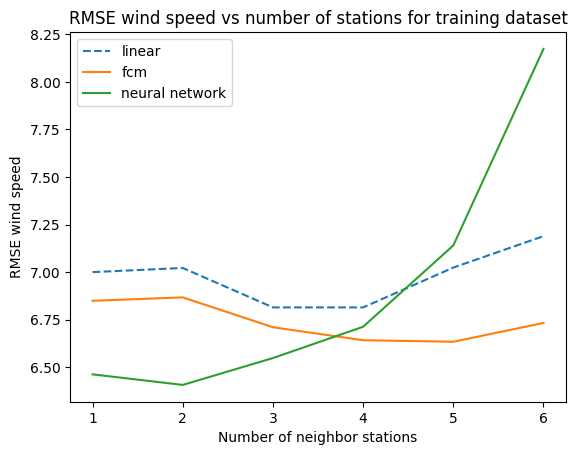

In [16]:
li_train_plot = []
fcm_train_plot = []
nn_train_plot = []
x_axis = number_of_neighbour_stations
for exp in training_results:
    li_train_plot.append(np.mean([d['linear_train'] for d in exp if 'linear_train' in d]))
    fcm_train_plot.append(np.mean([d['fcm_train'] for d in exp if 'fcm_train' in d]))
    nn_train_plot.append(np.mean([d['nn_train'] for d in exp if 'nn_train' in d]))

plt.plot(x_axis, li_train_plot, '--', label='linear')
plt.plot(x_axis, fcm_train_plot, label='fcm')
plt.plot(x_axis, nn_train_plot, label='neural network')
plt.legend(loc="upper left")
#plt.ylim(5)
plt.xlabel('Number of neighbor stations')
plt.ylabel('RMSE wind speed')
plt.title('RMSE wind speed vs number of stations for training dataset')

Text(0.5, 1.0, 'RMSE wind speed vs number of stations for validation dataset')

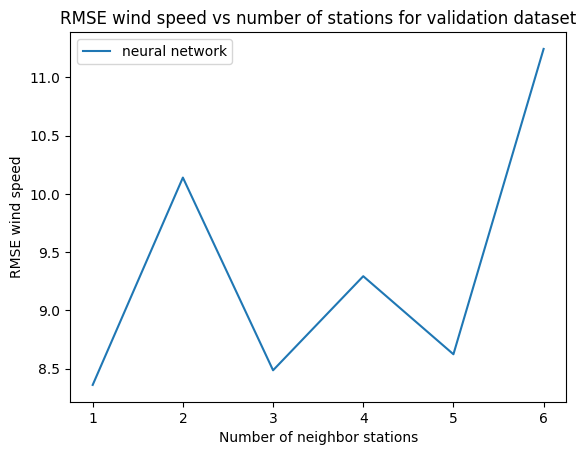

In [36]:

li_val_plot = []
fcm_val_plot = []
nn_val_plot = []
x_axis = number_of_neighbour_stations
for exp in validation_results:
    li_val_plot.append(np.mean([d['linear_val'] for d in exp if 'linear_val' in d]))
    fcm_val_plot.append(np.mean([d['fcm_val'] for d in exp if 'fcm_val' in d]))
    nn_val_plot.append(np.mean([d['nn_val'] for d in exp if 'nn_val' in d]))

#plt.plot(x_axis, li_val_plot, '--', label='linear')
#plt.plot(x_axis, fcm_val_plot, label='fcm', c='pink')
plt.plot(x_axis, nn_val_plot, label='neural network')
plt.legend(loc="upper left")
#plt.ylim(0,100)
plt.xlabel('Number of neighbor stations')
plt.ylabel('RMSE wind speed')
plt.title('RMSE wind speed vs number of stations for validation dataset')

Text(0.5, 1.0, 'Training and validation MSE for neural network model')

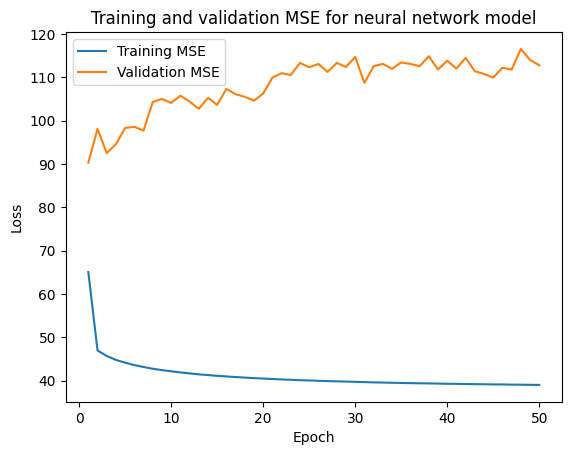

In [33]:
nn_histories

nn_val_plot = []
nn_train_plot = []
x_axis = range(1, number_of_epochs + 1)

exp = nn_histories[1]

nn_train_plot = [d['loss'] for d in exp if 'loss' in d]
nn_val_plot = [d['val_loss'] for d in exp if 'val_loss' in d]

plt.plot(x_axis, np.mean(nn_train_plot, axis=0), label='Training MSE')
plt.plot(x_axis, np.mean(nn_val_plot, axis=0), label='Validation MSE')
plt.legend(loc="upper left")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and validation MSE for neural network model')